In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hamza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [3]:
# Import the datatset
dataset = pd.read_csv('classifier_data_0.csv') 
col = ['owner', 'description']
dataset= dataset[col]

# Print the top
dataset.head()


,owner,description
0,amit@chromium.org,Product Version : <see about:version>URLs...
1,jon@chromium.org,Product Version : 0.2.149.27 (1583)URLs (...
2,pfeldman@chromium.org,Product Version : chrome beta 1URLs (if a...
3,jon@chromium.org,Product Version : 0.2.149.27 (1583)URLs (...
4,pkasting@chromium.org,Product Version : 0.2.149.27URLs (if appl...


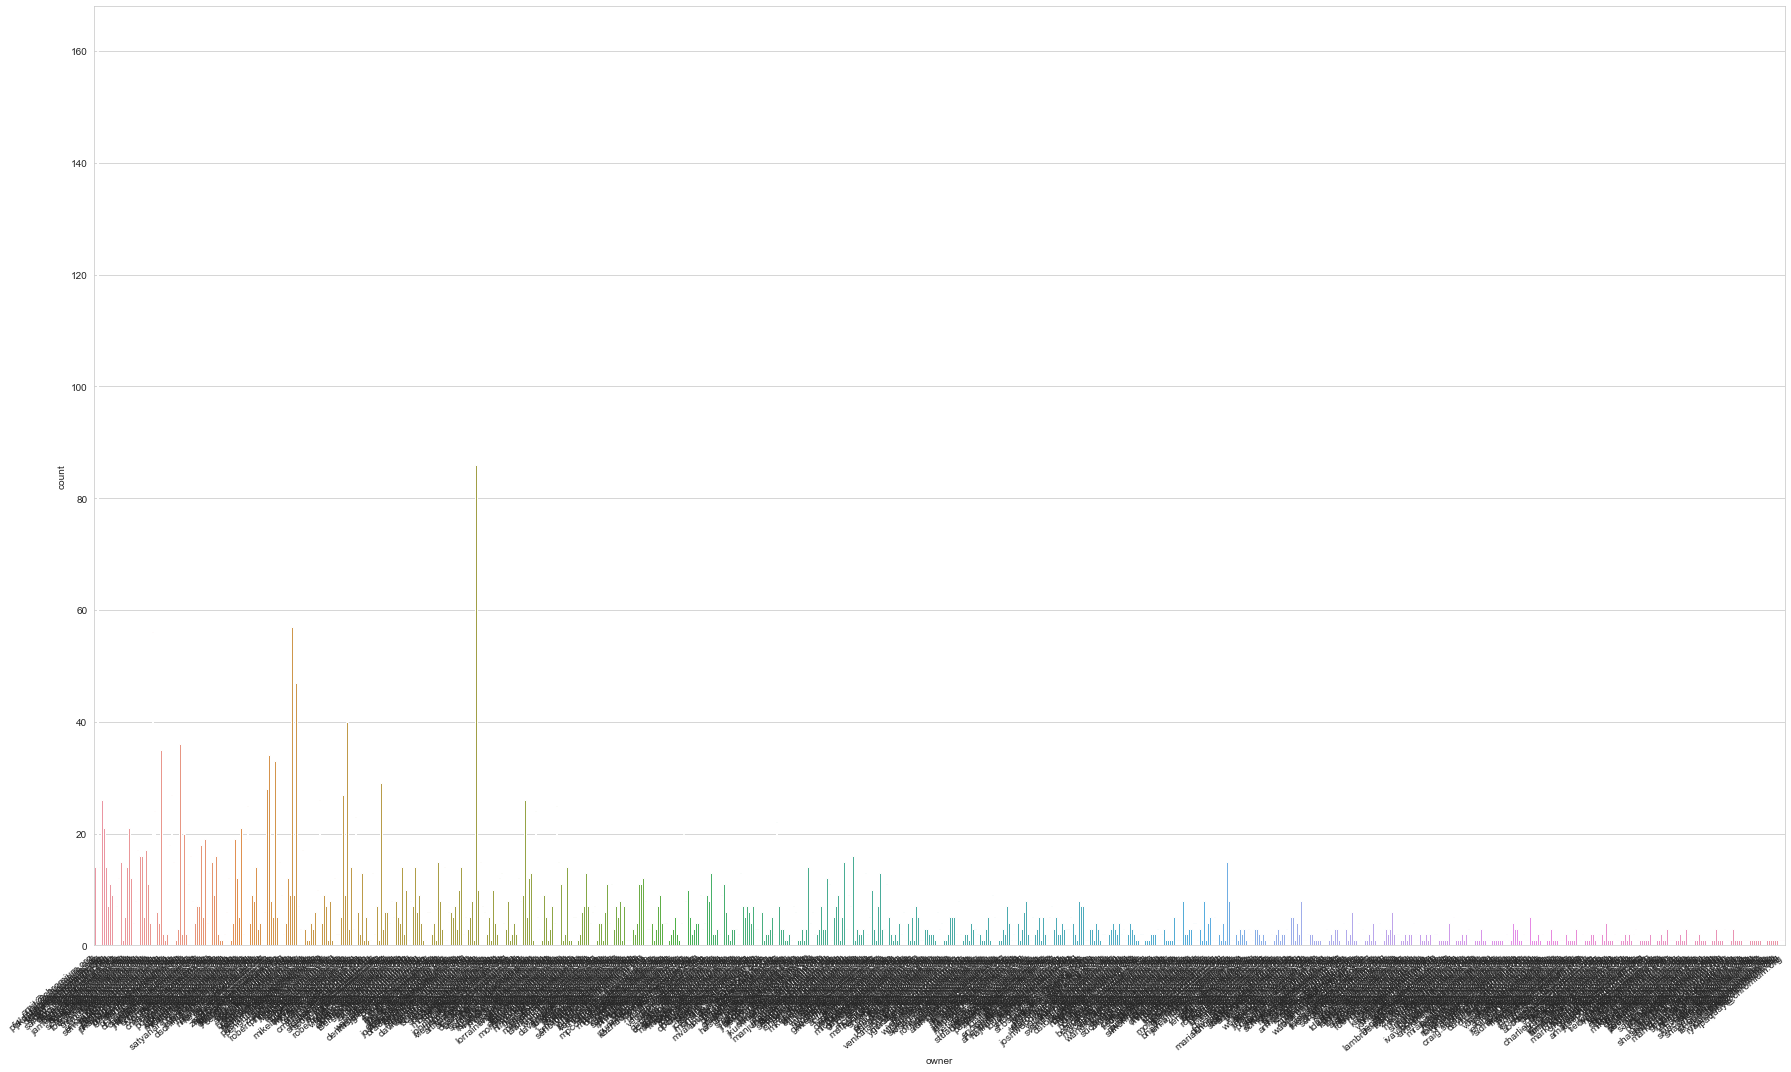

In [4]:
sns.set_style('whitegrid')
plt.figure(figsize=(25, 15))
ax = sns.countplot(x='owner', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [5]:
description = dataset["description"].values
owner = dataset[["owner"]].values

X_train, y_train, X_test, y_test = train_test_split(description, owner, test_size = 0.20, random_state = 42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


(4000,) (4000, 1)
(1000,) (1000, 1)


In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
dict(list(word_index.items())[0:10])

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_seq = tokenizer.texts_to_sequences(y_train)
validation_padded = pad_sequences(validation_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print('Shape of data tensor:', train_padded.shape)
print('Shape of data tensor:', validation_padded.shape)


Found 40248 unique tokens.
Shape of data tensor: (4000, 200)
Shape of data tensor: (1000, 200)


In [7]:
encode = OneHotEncoder(handle_unknown = 'ignore')

training_labels = encode.fit_transform(X_test)
validation_labels = encode.transform(y_test)

In [8]:
print(train_padded.shape)
print(validation_labels.shape)
print(validation_padded.shape)
print(training_labels.shape)
print(type(train_padded))
print(type(validation_padded))
print(type(training_labels))
print(type(validation_labels))

# The labels must be converted to arrays
# Convert the labels to arrays
training_labels = training_labels.toarray()
validation_labels = validation_labels.toarray()

print(type(training_labels))
print(type(validation_labels))

(4000, 200)
(1000, 735)
(1000, 200)
(4000, 735)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model.add(Conv1D(48, 5, activation='relu', padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 32

model.summary()
history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001), 
                              EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1),
                              EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          6400000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 48)           30768     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 48)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 48)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 48)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                

ValueError: in user code:

    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:755 train_step
        loss = self.compiled_loss(
    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\hamza\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (32, 735) and (32, 5) are incompatible
